# Simulating DSA-200 Images

From tyrones_stuff, simulate a very large image, e.g.:

`python sky_model.py --first ~/catalogs/first/first_14dec17.fits -o test_first.fits`

or

`python sky_model.py --first /fastpool/claw/catalogs/first/first_14dec17.fits --agn /fastpool/claw/catalogs/trecs/1sq_deg_sfgs/catalogue_AGNs_complete_1sqdeg.fits --sfg /fastpool/claw/catalogs/trecs/1sq_deg_sfgs/catalogue_SFGs_complete_1sqdeg.fits -o /fastpool/claw/images/dsa2k_first+trecsagnsfg_4096.fits --npix 4096 --target 0 0 1 1`

Details at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf.

TODO: add more sources and make larger area. be sure to set npix to produce correct pixel scale

The simulation process will apply image-plane modifications as they are applied by propagation and measurement (going "forward").
1. apply ionospheric screen
2. apply primary beam and cut out 16k x 16k field (~10 sq deg)
3. add noise
4. convolve with PSF

Then iterate over new screens and pointing directions to create a sequence of measurements of a "tile" (e.g., 5x5).a

## Setup

In [7]:
import os.path
from scipy.interpolate import RBFInterpolator, CloughTocher2DInterpolator
from multiprocess import Pool
from typing import Literal, Tuple, Union
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.wcs as wcs
from astropy.io import fits

import numpy as np
from jax.scipy.signal import convolve
import jax.numpy as jnp
from jaxtyping import Array
import pandas as pd

In [8]:
from data import fits_image
from util import indices, rescale_quantile, gaussian_filter, match_histograms
from interactive import toggle_images, plot_image, sequence_images

## Create image

In [157]:
#!cd /home/claw/code/tyrones_stuff

In [158]:
#!python sky_model.py --first /fastpool/claw/catalogs/first/first_14dec17.fits -o /fastpool/claw/images/test.fits --npix 1024  --target 0 0 0.25 0.25

In [159]:
#input_image = '/fastpool/claw/images/test.fits'
#image, imwcs = fits_image(input_image)
#print(image.std(), image.min(), image.max())
#plot_image(image, vmin=image.min(), vmax=image.max())

In [160]:
def compute_offsets(dxmodel, dymodel):
    # compute each row separately
    def calc_row(r):
        # all indices with row r
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()  
        xy[:, 0] = r
        row_offsets = np.stack((dxmodel(xy), dymodel(xy)), axis=-1)
        return row_offsets
    
    # Naive multiprocessing (computing each row separately):
    # Note: while this should be extremely parallelizable , something (likely the GIL)
    # is preventing us from achieving optimal performance. This seems to take about 3
    # minutes with multiprocessing (64 cores) and 4.5 minutes without. Thus, Amdahl's
    # law tells us that only about 25% of this task is parallelizable (though it
    # should be closer to 100%).
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(calc_row, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
        return res

    results = go()
    return np.concatenate(results)

def compute_interpolation(interp):
    def g(r):
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()
        xy[:, 0] = r
        return interp(xy)
    
    # naive multiprocessing, see above
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(g, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
                
        return res

    results = go()
    interp_img = np.stack(results, axis=0)
    return interp_img


In [161]:
def reference_sources_nvss(catalog, min_flux=270) -> Tuple[SkyCoord, Array]:
    nvss = pd.read_csv(catalog, sep=r"\s+")
    sorted_nvss = nvss.sort_values(by=["f"])

    # cut off refernce sources below a certain flux density
    sorted_nvss = sorted_nvss[sorted_nvss["f"] >= min_flux]

    # get coordinates of each reference source
    nvss_orig = sorted_nvss[["rah", "ram", "ras", "dd", "dm", "ds"]].to_numpy()

    # get flux of each reference source in Jy
    fluxes = sorted_nvss[["f"]].to_numpy().squeeze() / 1000

    # manually convert HMS:DMS into degrees
    nvss_ra = (
        15 * nvss_orig[:, 0]
        + (15 / 60) * nvss_orig[:, 1]
        + (15 / 3600) * nvss_orig[:, 2]
    )
    nvss_dec = (
        nvss_orig[:, 3] + (1 / 60) * nvss_orig[:, 4] + (1 / 3600) * nvss_orig[:, 5]
    )

    positions = np.stack((nvss_ra, nvss_dec), axis=-1)

    return SkyCoord(positions, unit=(u.deg, u.deg)), jnp.array(fluxes)

In [162]:
def gkern(l=5, sig=1.0):
    """\
    Creates gaussian kernel with side length `l` and a sigma of `sig`.
    Reaches a maximum of 1 at its center value
    """
    ax = jnp.linspace(-(l - 1) / 2.0, (l - 1) / 2.0, l)
    gauss = jnp.exp(-0.5 * jnp.square(ax) / jnp.square(sig))
    kernel = jnp.outer(gauss, gauss)
    return kernel / kernel.max()

In [163]:
def pbcut(img, center, size):
    """ Multiple by Gaussian primary beam at location center (in (x,y) pixel coords) and width size (pixels).
    """
    pb_kernel = gkern(size, size/4)  # TODO figure out width
    return np.array(img[(center[0]-size//2):(center[0]+size//2), (center[1]-size//2):(center[1]+size//2)]*pb_kernel)

## 1. Read image

In [223]:
# Details on simulation at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf
#input_image = '/fastpool/claw/images/test.fits'  # toy image at 1350 MHz and FIRST catalog
input_image = '/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192.fits'

In [224]:
image, imwcs = fits_image(input_image)

In [225]:
IMAGE_SIZE = image.shape[0]
CPU_COUNT = 2
WORKING_DIR = '/fastpool/claw/images/'
print(f'Image size: {IMAGE_SIZE}')

Image size: 1024


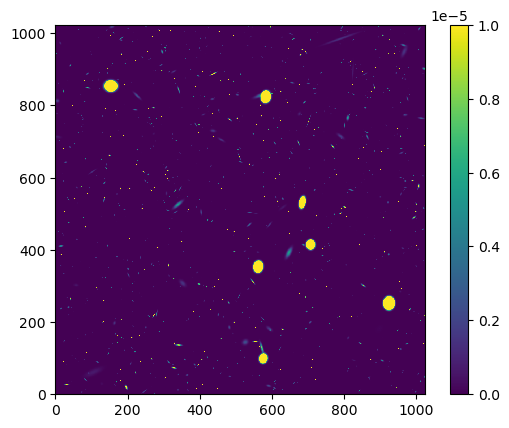

In [226]:
im = fits.open(input_image)[0].data.squeeze()
plot_image(im, vmin=im.min(), vmax=0.00001)

## 2. Add noise

In [227]:
noise_sigma = 1e-8
# TODO: find best PSF
psf_filename = '/fastpool/data/W-GC-8000chan-briggs09-psf.fits'
psf_image, psf_wcs = fits_image(psf_filename)

# normalization factor for core of PSF that overlaps input image
psf_width = psf_image.squeeze().shape[0]
psf_norm = psf_image.squeeze()[psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2,
                               psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2].sum()

print(psf_norm)

32.123516


In [228]:
psf_width, IMAGE_SIZE

(16000, 1024)

In [229]:
psf_image.sum()

Array(-3.3968792, dtype=float32)

In [230]:
hdu = fits.open(input_image)[0]
image = np.ma.masked_invalid(hdu.data.squeeze())
image.set_fill_value(0)
hdr = hdu.header
noise = np.random.normal(0, noise_sigma, size=image.shape)  # zero mean
noise_convolved = convolve(noise, psf_image/psf_norm, mode="same", method="fft")

print(noise_convolved.std())

1.4105805e-09


In [231]:
noise_convolved = np.array(noise_convolved)

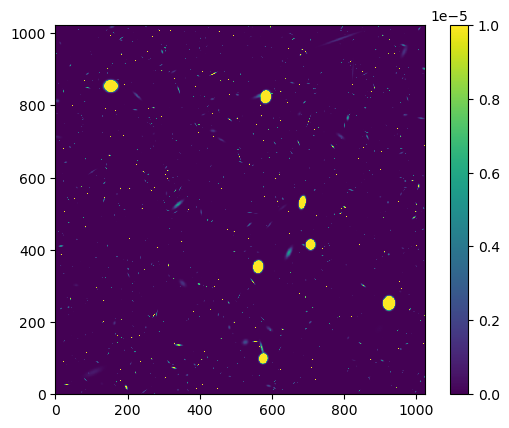

In [232]:
image_noise = image.filled()+noise_convolved
plot_image(image_noise, vmax=1e-5)

## 3. Convolve image with PSF 

In [233]:
# note that noise is double convolved
image_convolved = convolve(image_noise, psf_image/psf_norm, mode="same", method="fft")

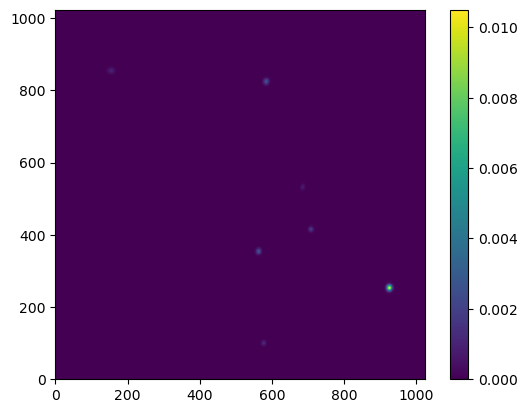

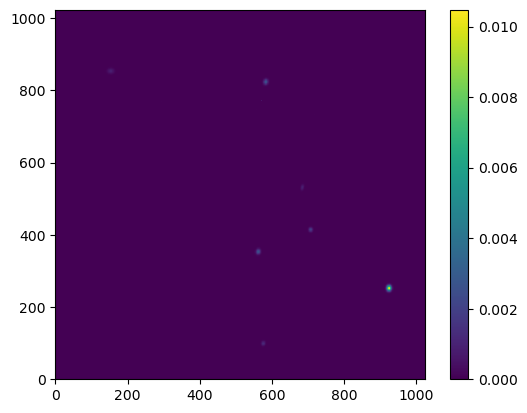

In [234]:
plot_image(image_convolved, vmax=image_convolved.max())
plot_image(im, vmax=im.max())

In [235]:
fits.writeto(input_image.replace('.fits', 'noiseconv2.fits'), image_convolved, header=hdr, overwrite=True)

## Catalog of sky model

In [237]:
import catalog_utils
tbf, tbs, tba = catalog_utils.mask([[-1*u.deg, -1*u.deg], [1*u.deg, 1*u.deg]],
                                   first=catalog_utils.get_srcs('/fastpool/claw/catalogs/first/first_14dec17.fits', 'first'),
                                   sfg=catalog_utils.get_srcs('/fastpool/claw/catalogs/trecs/5sq_deg/catalogue_SFGs_complete_5sqdeg.fits', 'trecs-sfg'),
                                   agn=catalog_utils.get_srcs('/fastpool/claw/catalogs/trecs/5sq_deg/catalogue_AGNs_complete_5sqdeg.fits', 'trecs-agn'))

In [276]:
#sfg
dfs = tbs[['I1350', 'longitude', 'latitude']].to_pandas()
s = tbs
ecc = np.sqrt(s["e1"].value**2 + s["e2"].value**2)  # eccentricity                                                               
major = 1 / (1 - ecc) * s["size"].value
minor = 1 / (1 + ecc) * s["size"].value
rot = np.arctan2(s["e1"].value, s["e2"].value)  # position angle
dfs.insert(3, 'major', major)
dfs.insert(4, 'minor', minor)
dfs.insert(5, 'posang', rot)
dfs.rename(columns={'I1350': 'FPEAK', 'longitude': 'RA', 'latitude': 'DEC'}, inplace=True)

#agn
s = tba
major = np.cast[float](tba['size'])
rs = np.cast[float](tba['Rs'])
minor = major * np.cast[float](rs)
posang = np.zeros_like(major)
dfa = tba[['I1350', 'longitude', 'latitude']].to_pandas()
dfa.insert(3, 'major', major)
dfa.insert(4, 'minor', minor)
dfa.insert(5, 'posang', posang)
dfa.rename(columns={'I1350': 'FPEAK', 'longitude': 'RA', 'latitude': 'DEC'}, inplace=True)

#first
dff = tbf[['FPEAK', 'RA', 'DEC', 'FITTED_MAJOR', 'FITTED_MINOR', 'POSANG']].to_pandas()
dff.rename(columns={'FITTED_MAJOR': 'major', 'FITTED_MINOR': 'minor', 'POSANG': 'posang'}, inplace=True)

In [282]:
df = pd.concat([dfs, dfa, dff])

In [285]:
df.sort_values('FPEAK')

,FPEAK,RA,DEC,major,minor,posang
19760,0.010000,-0.125741,0.503593,0.651597,0.521428,2.081630
22614,0.010001,-0.877179,0.796149,0.654593,0.549351,1.309286
31407,0.010001,0.314246,0.809984,0.292161,0.247659,1.774381
24961,0.010002,-0.074368,-0.440062,0.280339,0.197393,2.350664
32358,0.010002,0.625430,0.597525,0.272828,0.228951,2.313788
...,...,...,...,...,...,...
1228,209.495407,-0.966087,-0.907596,13.514781,1.660365,0.000000
2085,270.847443,-0.580351,-0.418928,2.741231,0.340125,0.000000
207,297.449036,0.343719,0.525770,11.781744,2.030255,0.000000
4372,309.529297,0.349522,0.175111,0.000025,0.000000,0.000000
